## Summary of Notebook

This notebook contains the implementation of the EfficientNetB0 model with unforzen architecture. It provides the results obtained from this model and its performance across the training, validation, and testing phases.

## Set Up
Here, we will begin by downloading the necessary dataset for flowers102, followed by the creation of dataloaders and the implementation of train and test functions.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from scipy.io import loadmat
import pandas as pd
from torch.utils.data import Dataset
import json

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [3]:
train_dataset = torchvision.datasets.Flowers102("./data/train", split="train", download=True, transform=data_transforms["train"])
val_dataset = torchvision.datasets.Flowers102("./data/val", split="val", download=True, transform=data_transforms["val"])
test_dataset = torchvision.datasets.Flowers102("./data/test", split="test", download=True, transform=data_transforms["test"])

In [4]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

In [5]:
dataloaders = {}
dataloaders["train"] = train_dataloader
dataloaders["val"] = val_dataloader
dataloaders["test"] = test_dataloader

In [6]:
dataset_sizes = {}
dataset_sizes["train"] = len(train_dataloader.dataset)
dataset_sizes["val"] = len(val_dataloader.dataset)
dataset_sizes["test"] = len(test_dataloader.dataset)

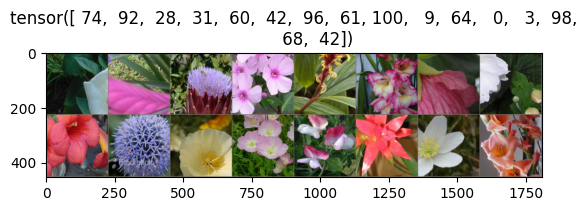

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=classes)



In [8]:
def test_model(model, criterion):
    # Ensure the model is on the CPU
    model.to("cpu")
    model.eval()  # Set model to evaluation mode
    
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():  # Disable gradient calculations for testing
        for inputs, labels in dataloaders["test"]:
            # Ensure inputs and labels remain on CPU
            inputs = inputs.cpu()
            labels = labels.cpu()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Accumulate loss and correct predictions
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

    # Calculate average loss and accuracy
    total_loss = running_loss / dataset_sizes["test"]
    total_acc = running_corrects.double() / dataset_sizes["test"]

    return total_loss, total_acc


In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_accuracies = []
    val_accuracies = []

    # Explicitly set the device to CPU
    device = torch.device("cpu")
    model = model.to(device)  # Ensure model is on the CPU

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluation mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over the data.
                for inputs, labels in dataloaders[phase]:
                    # Ensure inputs and labels are on the CPU
                    inputs = inputs.to(device, dtype=torch.float32)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass (track history if only in train)
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                # Store accuracy for each epoch
                if phase == "train":
                    train_accuracies.append(epoch_acc.item())
                else:
                    val_accuracies.append(epoch_acc.item())

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Deep copy the model if validation accuracy improves
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        # Load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    
    return model, train_accuracies, val_accuracies


In [10]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model_conv = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model_conv = efficientnet_b0(weights="DEFAULT")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Modify Last Layer and Train the Entire Model with the Pre-trained Weights

In this section, we will train the EfficientB0 model on the flowers102 dataset. Our only modification will be adjusting the last layer to have 102 neurons. The remaining architecture of EfficientB0 will remain unchanged, with all other layers unfrozen.

In [11]:
model_ft = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model_ft = efficientnet_b0(weights="DEFAULT")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
num_ftrs = model_ft.classifier[1].in_features


model_ft.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(num_ftrs, 102),
        )


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
model_ft, train_accuracies_ft, val_accuracies_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 4.1732 Acc: 0.1480
val Loss: 2.5623 Acc: 0.5324

Epoch 1/24
----------
train Loss: 2.1757 Acc: 0.5667
val Loss: 1.0974 Acc: 0.7725

Epoch 2/24
----------
train Loss: 1.1073 Acc: 0.7569
val Loss: 0.6068 Acc: 0.8637

Epoch 3/24
----------
train Loss: 0.6725 Acc: 0.8422
val Loss: 0.4509 Acc: 0.8912

Epoch 4/24
----------
train Loss: 0.5303 Acc: 0.8843
val Loss: 0.4071 Acc: 0.9000

Epoch 5/24
----------
train Loss: 0.3953 Acc: 0.9216
val Loss: 0.3504 Acc: 0.9049

Epoch 6/24
----------
train Loss: 0.3709 Acc: 0.9127
val Loss: 0.3857 Acc: 0.8961

Epoch 7/24
----------
train Loss: 0.3169 Acc: 0.9294
val Loss: 0.3115 Acc: 0.9235

Epoch 8/24
----------
train Loss: 0.2684 Acc: 0.9500
val Loss: 0.2774 Acc: 0.9314

Epoch 9/24
----------
train Loss: 0.2390 Acc: 0.9520
val Loss: 0.2710 Acc: 0.9324

Epoch 10/24
----------
train Loss: 0.2255 Acc: 0.9490
val Loss: 0.2609 Acc: 0.9382

Epoch 11/24
----------
train Loss: 0.1970 Acc: 0.9588
val Loss: 0.2603 Acc: 0.9373

Ep

C:\Users\Arnav\AppData\Local\Temp\ipykernel_105800\9640722.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


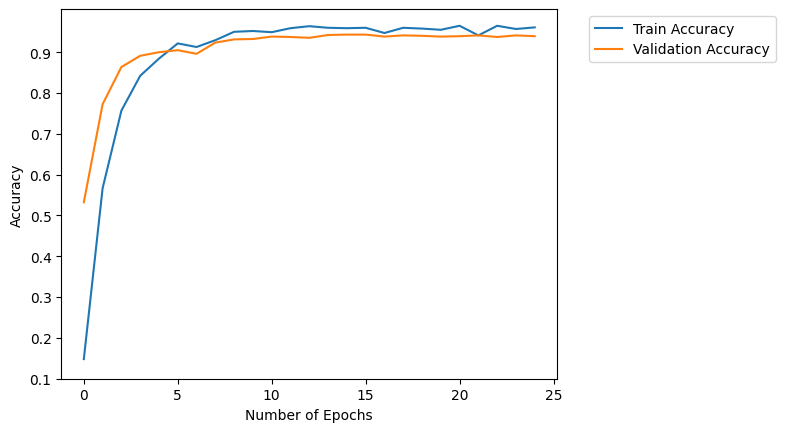

In [14]:
plt.plot(range(25), train_accuracies_ft, label="Train Accuracy")
plt.plot(range(25), val_accuracies_ft, label="Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.yticks(np.arange(0.1, 1, 0.1))
plt.show()

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()  # Set model to evaluation mode
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            # Ensure inputs and labels remain on CPU
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {preds[j]} vs true: {labels[j]}')
                imshow(inputs.data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
    model.train(mode=was_training)

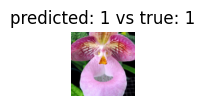

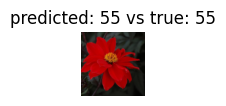

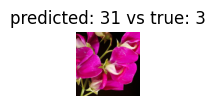

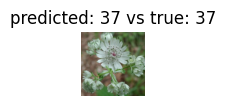

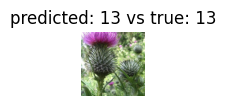

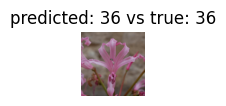

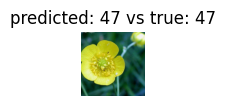

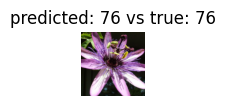

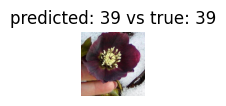

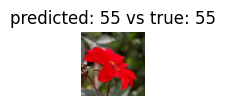

In [16]:
visualize_model(model_ft, num_images=10)

In [17]:
# test accuracies for the 3 models
criterion = nn.CrossEntropyLoss()
loss_ft, accuracy_ft = test_model(model_ft, criterion)

In [18]:
print(f"{ 'Test Loss (No Freeze)'.ljust(30) } : {loss_ft:.4f}")
print(f"{ 'Test Accuracy (No Freeze)'.ljust(30) } : {accuracy_ft:.4f}")

Test Loss (No Freeze)          : 0.2957
Test Accuracy (No Freeze)      : 0.9211
